In [ ]:
run_project = input("Czy chcesz uruchomić projekt? (tak/nie): ").lower()

if run_project != 'tak':
    raise SystemExit("Projekt nie zostanie uruchomiony.")
print("Projekt uruchomiony.")

## Biblioteki

In [ ]:
!pip install feature_engine
from pathlib import Path
import os
import re
from collections import OrderedDict
from feature_engine.outliers import Winsorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import loguniform, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    KBinsDiscretizer,
    OneHotEncoder,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_validate,
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from IPython.display import display
import joblib
import kagglehub
import pathlib
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 4.8 MB/s eta 0:00:00


## EDA

Załadowano 100000 wierszy i 9 kolumn.



,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB

Statystyki opisowe:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,100000,3,Female,58552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.0,NaN,NaN,NaN,41.885856,22.51684,0.08,24.0,43.0,60.0,80.0
hypertension,100000.0,NaN,NaN,NaN,0.07485,0.26315,0.0,0.0,0.0,0.0,1.0
heart_disease,100000.0,NaN,NaN,NaN,0.03942,0.194593,0.0,0.0,0.0,0.0,1.0
smoking_history,100000,6,No Info,35816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,100000.0,NaN,NaN,NaN,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,NaN,NaN,NaN,5.527507,1.070672,3.5,4.8,5.8,6.2,9.0
blood_glucose_level,100000.0,NaN,NaN,NaN,138.05806,40.708136,80.0,100.0,140.0,159.0,300.0
diabetes,100000.0,NaN,NaN,NaN,0.085,0.278883,0.0,0.0,0.0,0.0,1.0



Rozkład klas:


,count
diabetes,
Brak cukrzycy,91500
Cukrzyca,8500


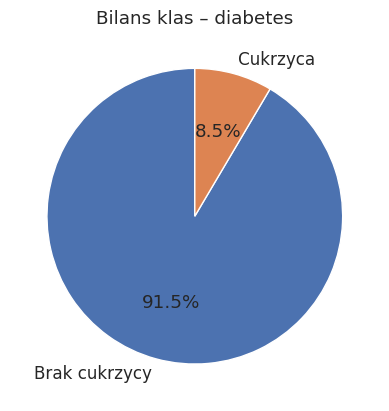


Braki danych w kolumnach:


,Liczba braków
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


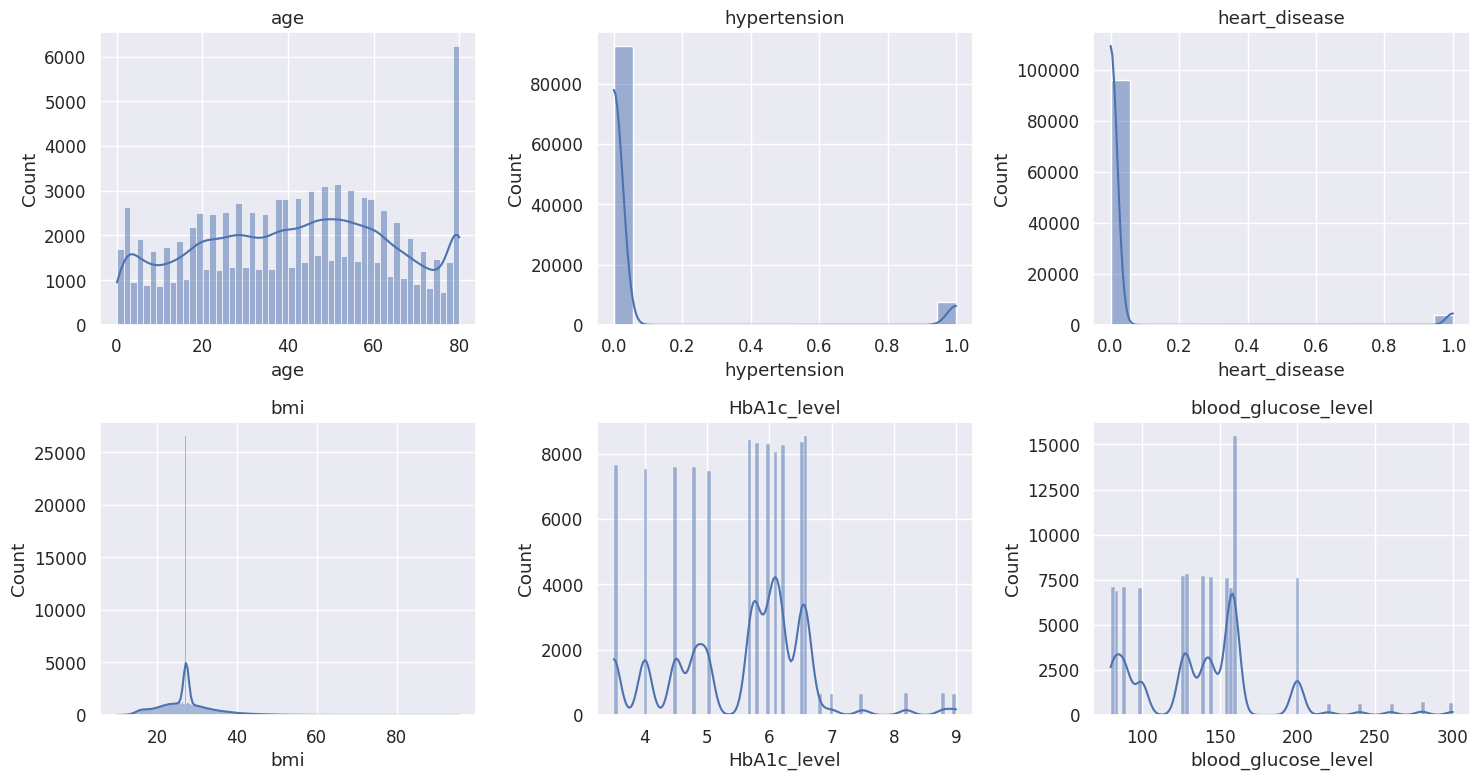

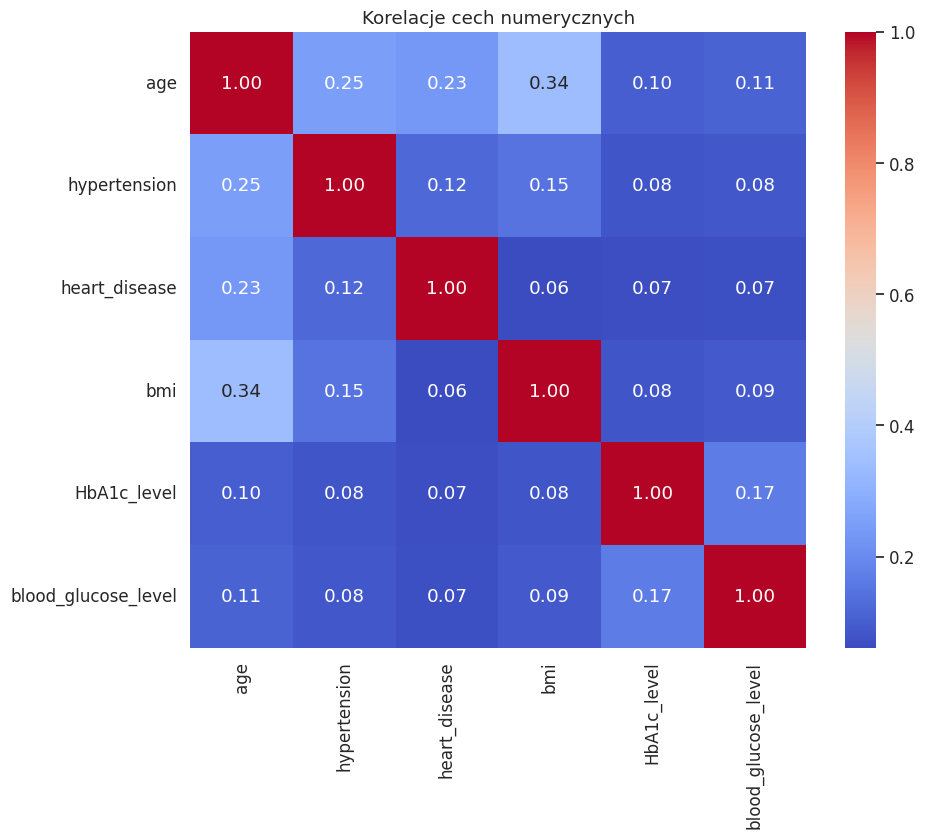

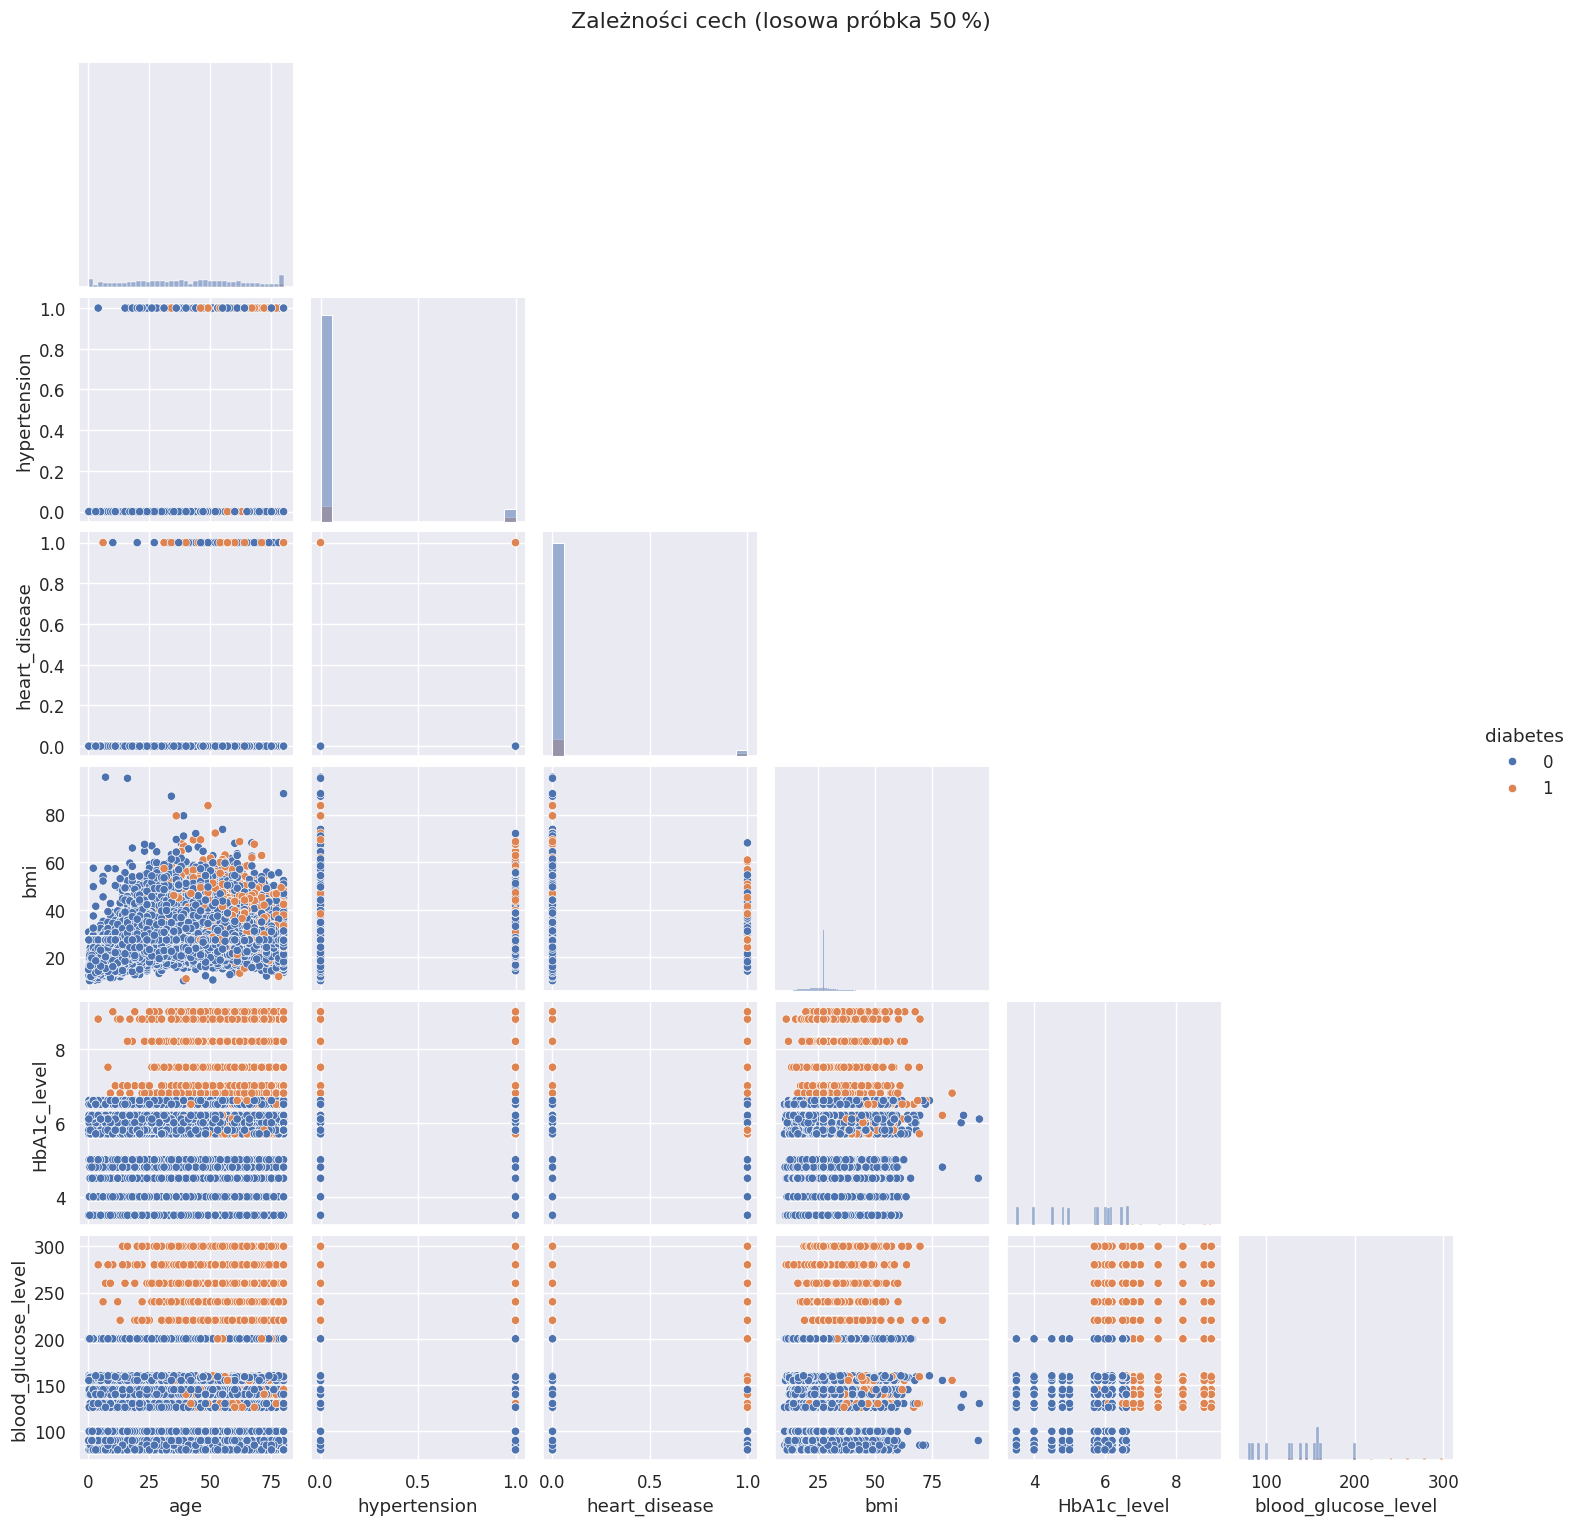

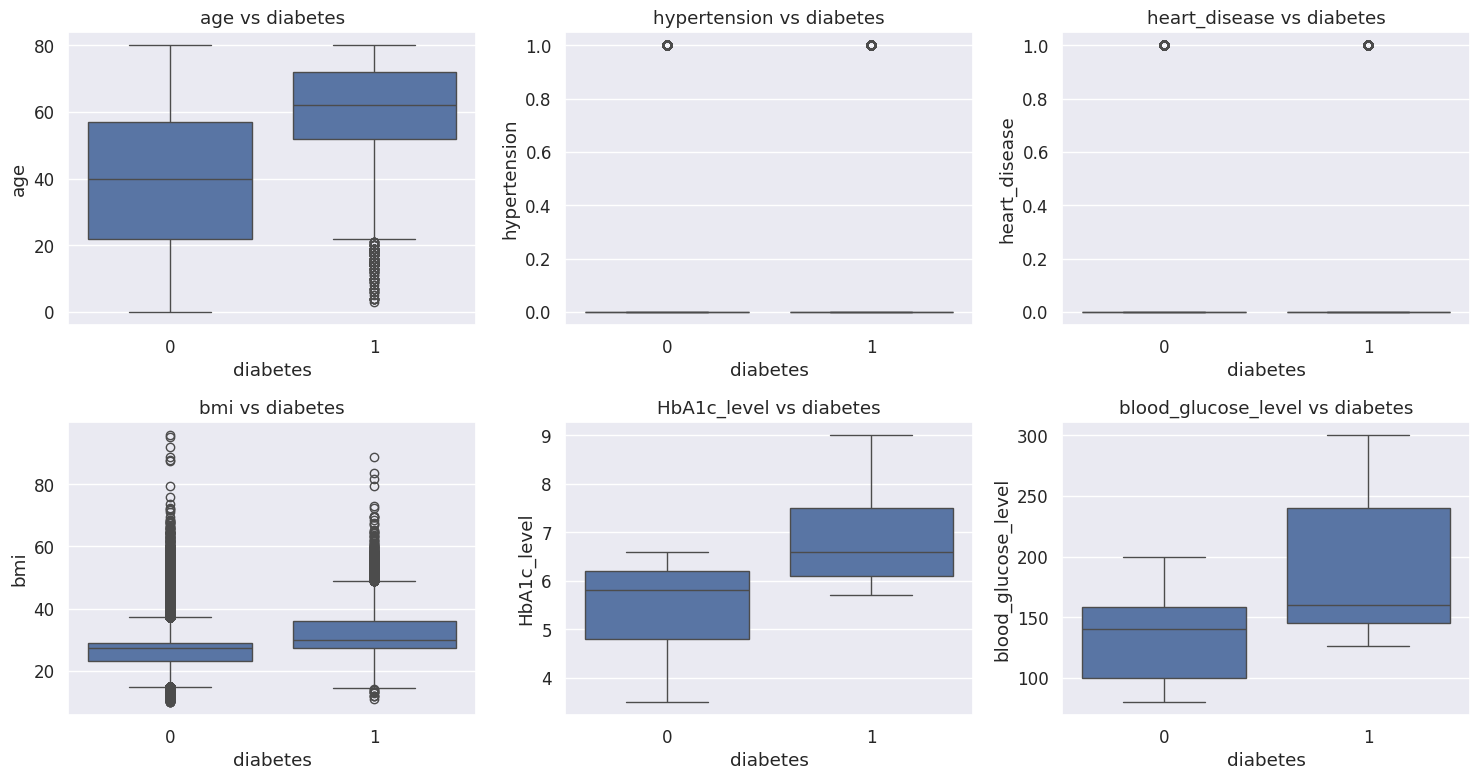

In [ ]:
plt.style.use("default")  # ustawienie stylu wykresów
sns.set(font_scale=1.1)  # skala czcionki
pd.set_option("display.max_columns", None)  # wyświetlanie wszystkich kolumn

path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")  # pobranie danych
path = pathlib.Path(path)  # konwersja ścieżki
csv_file = next(path.glob("*.csv"))  # wyszukanie pliku CSV
df = pd.read_csv(csv_file.as_posix())  # wczytanie danych

if df["diabetes"].dtype == object:  # detekcja typu zmiennej
    df["diabetes"] = (  # konwersja etykiet
        df["diabetes"]
        .str.strip()
        .str.lower()
        .map({"positive": 1, "yes": 1, "negitive": 0, "negative": 0, "no": 0})
        .astype(int)
    )

target = "diabetes"  # zmienna celu
feature_cols = df.columns.drop(target)  # wybór cech

print(f"Załadowano {df.shape[0]} wierszy i {df.shape[1]} kolumn.\n")  # podsumowanie rozmiaru
display(df.head())  # podgląd danych
df.info()  # struktura DataFrame

print("\nStatystyki opisowe:")  # nagłówek statystyk
display(df.describe(include="all").T)  # statystyki opisowe

class_counts = df[target].value_counts().rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"})  # zliczenie klas
print("\nRozkład klas:")  # nagłówek rozkładu
display(class_counts)  # wyświetlenie rozkładu

fig, ax = plt.subplots()  # inicjalizacja wykresu
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)  # wykres kołowy
ax.set_title(f"Bilans klas – {target}")  # tytuł wykresu
plt.show()  # wyświetlenie wykresu

missing_summary = df.isna().sum().to_frame("Liczba braków")  # podsumowanie braków danych
print("\nBraki danych w kolumnach:")  # nagłówek braków
display(missing_summary)  # wyświetlenie braków

num_cols = df[feature_cols].select_dtypes(include="number").columns  # cechy numeryczne
n = len(num_cols)  # liczba cech
cols = 3  # kolumny wykresów
rows = (n + cols - 1) // cols  # wiersze wykresów
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))  # siatka wykresów
axes = axes.flatten()  # spłaszczenie osi
for ax, col in zip(axes, num_cols):  # iteracja po cechach
    sns.histplot(df[col], kde=True, ax=ax)  # histogram z KDE
    ax.set_title(col)  # tytuł pod wykresem
for ax in axes[len(num_cols):]:  # pozostałe puste osie
    ax.axis("off")  # wyłączenie osi
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów

corr = df[num_cols].corr()  # macierz korelacji
plt.figure(figsize=(10, 8))  # rozmiar mapy cieplnej
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)  # wykres korelacji
plt.title("Korelacje cech numerycznych")  # tytuł mapy
plt.show()  # wyświetlenie mapy

sns.pairplot(df.sample(frac=0.5, random_state=42), hue=target,
             vars=num_cols, diag_kind="hist", corner=True)  # analiza par cech
plt.suptitle("Zależności cech (losowa próbka 50 %)", y=1.02)  # tytuł zbiorczy
plt.show()  # wyświetlenie pairplot

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))  # inicjalizacja siatki wykresów pudełkowych
axes = axes.flatten()  # spłaszczenie osi
for ax, col in zip(axes, num_cols):  # iteracja po cechach
    sns.boxplot(x=target, y=col, data=df, ax=ax)  # wykres pudełkowy
    ax.set_title(f"{col} vs {target}")  # tytuł pod wykresem
for ax in axes[len(num_cols):]:  # pozostałe puste osie
    ax.axis("off")  # wyłączenie osi
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów pudełkowych


## Preprocessing

In [ ]:
target = "diabetes"  # etykieta
feature_cols = df.columns.drop(target)  # wybór cech

X = df[feature_cols].copy()  # dane wejściowe
y = df[target].copy()  # etykiety

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,  # udział zbioru testowego
    stratify=y,  # zachowanie proporcji klas
    random_state=42  # ziarno losowości
)  # podział danych

class Winsorizer(BaseEstimator, TransformerMixin):  # klasa przycinająca wartości
    def __init__(self, lower_q=0.01, upper_q=0.99):  # parametry kwantyli
        self.lower_q = lower_q  # kwantyl dolny
        self.upper_q = upper_q  # kwantyl górny
    def fit(self, X, y=None):  # obliczenie progów
        arr = X if isinstance(X, np.ndarray) else X.to_numpy()  # konwersja tablicy
        q_low  = np.nanquantile(arr, self.lower_q, axis=0)  # obliczenie dolnego kwantyla
        q_high = np.nanquantile(arr, self.upper_q, axis=0)  # obliczenie górnego kwantyla
        self.bounds_ = np.vstack([q_low, q_high]).T  # utworzenie macierzy progów
        return self  # zwrócenie instancji
    def transform(self, X):  # przycinanie wartości
        arr = X if isinstance(X, np.ndarray) else X.to_numpy()  # konwersja tablicy
        for i in range(arr.shape[1]):  # iteracja po cechach
            lo, hi = self.bounds_[i]  # zakres przycinania
            arr[:, i] = np.clip(arr[:, i], lo, hi)  # przycięcie wartości
        return arr  # zwrócenie przetworzonych danych

numeric_cols = df[feature_cols].select_dtypes(include="number").columns.tolist()  # cechy numeryczne
categorical_cols  = df[feature_cols].select_dtypes(exclude="number").columns.tolist()  # cechy kategoryczne

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),  # imputacja medianą
    ("winsor",  Winsorizer(0.01, 0.99)),  # winsoryzacja wartości
    ("binning", KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="quantile")),  # dyskretyzacja
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # imputacja najczęstsza
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # kodowanie one-hot
])

preprocess_ct = ColumnTransformer([
    ("num", num_pipe, numeric_cols),  # przetwarzanie numerycznych
    ("cat", cat_pipe, categorical_cols),  # przetwarzanie kategorycznych
], remainder="drop")  # odrzucenie pozostałych

prep_pipeline = ImbPipeline([
    ("preprocess",  preprocess_ct),  # etap preprocessingu
    ("undersample", RandomUnderSampler(random_state=42)),  # undersampling
])

X_train_proc, y_train_bal = prep_pipeline.fit_resample(X_train, y_train)  # dopasowanie i balansowanie
X_test_proc = prep_pipeline.named_steps["preprocess"].transform(X_test)  # transformacja zbioru testowego

print(f"Po preprocessingu: X_train={X_train_proc.shape}, X_test={X_test_proc.shape}")  # podsumowanie rozmiarów
print("Rozkład klas po undersamplingu w train:", np.bincount(y_train_bal))  # rozkład klas


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(


Po preprocessingu: X_train=(13600, 31), X_test=(20000, 31)
Rozkład klas po undersamplingu w train: [6800 6800]


## EDA po preprocessingu

Przetworzone kolumny: 31


,age_bin0,age_bin1,age_bin2,age_bin3,age_bin4,hypertension_bin0,heart_disease_bin0,bmi_bin0,bmi_bin1,bmi_bin2,bmi_bin3,bmi_bin4,HbA1c_level_bin0,HbA1c_level_bin1,HbA1c_level_bin2,HbA1c_level_bin3,HbA1c_level_bin4,blood_glucose_level_bin0,blood_glucose_level_bin1,blood_glucose_level_bin2,blood_glucose_level_bin3,blood_glucose_level_bin4,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


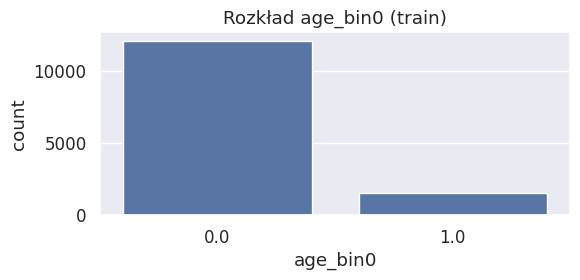

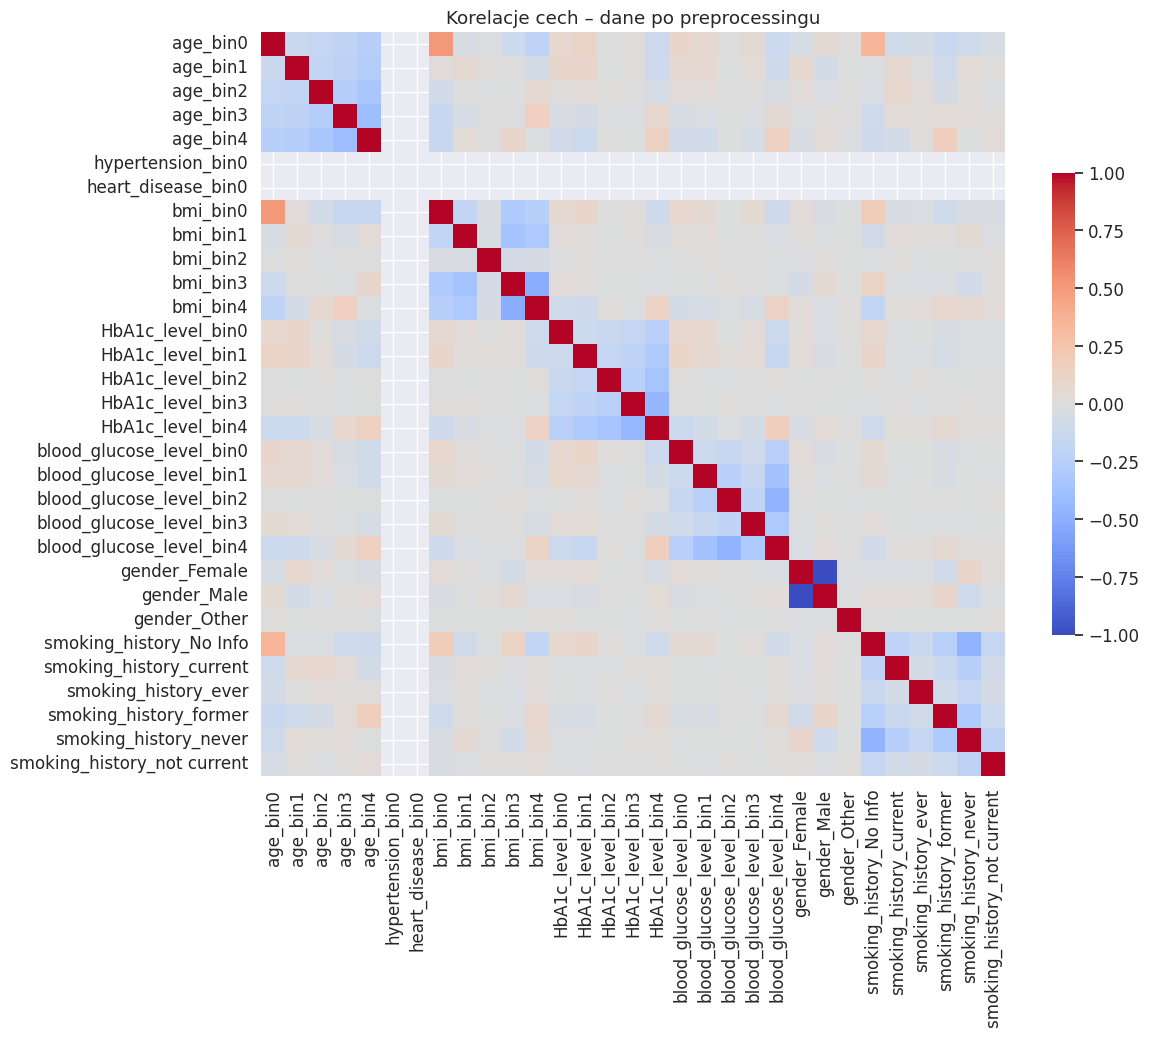

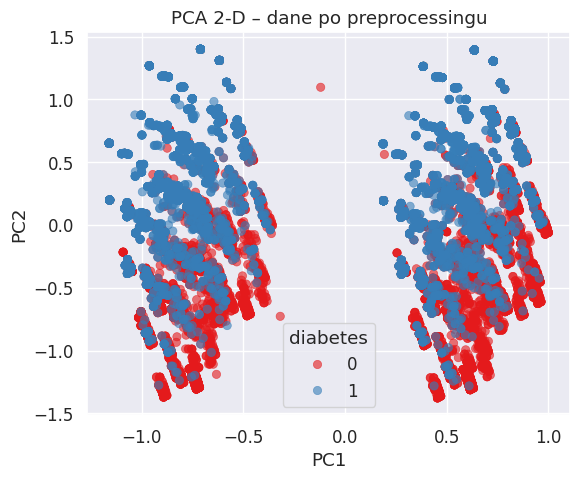

Bilans klas w zbiorze train po preprocessingu:


,count
diabetes,
Brak cukrzycy,6800
Cukrzyca,6800


In [ ]:
ct = prep_pipeline.named_steps["preprocess"]  # ekstrakcja preprocessingu

binning = ct.named_transformers_["num"].named_steps["binning"]  # pobranie biningu
n_bins  = [len(edges) - 1 for edges in binning.bin_edges_]  # liczba przedziałów
feat_binned = [
    f"{col}_bin{idx}"
    for col, nb in zip(numeric_cols, n_bins)  # iteracja po cechach numerycznych
    for idx in range(nb)  # iteracja po przedziałach
]

missing_idx  = ct.named_transformers_["num"].named_steps["imputer"].indicator_.features_  # indeksy braków
feat_missing = [f"{numeric_cols[i]}_missing" for i in missing_idx]  # nazwy wskaźników braków

encoder = ct.named_transformers_["cat"].named_steps["encoder"]  # pobranie enkodera
cat_feature_names = [
    f"{col}_{cat}"
    for col, cats in zip(categorical_cols, encoder.categories_)  # iteracja po cechach kategorycznych
    for cat in cats  # iteracja po kategoriach
]

proc_cols = feat_binned + feat_missing + cat_feature_names  # lista przetworzonych kolumn

X_train_df = pd.DataFrame(X_train_proc, columns=proc_cols)  # utworzenie DataFrame train
X_test_df  = pd.DataFrame(X_test_proc,  columns=proc_cols)  # utworzenie DataFrame test

print("Przetworzone kolumny:", len(proc_cols))  # liczba kolumn
display(X_train_df.head())  # podgląd danych

if feat_binned:  # warunek rysowania wykresu
    sample_feat = feat_binned[0]  # przykładowa cecha
    plt.figure(figsize=(6, 3))  # inicjalizacja figury
    sns.countplot(x=sample_feat, data=X_train_df)  # wykres liczebności
    plt.title(f"Rozkład {sample_feat} (train)")  # tytuł wykresu
    plt.tight_layout()  # układ wykresu
    plt.show()  # wyświetlenie wykresu

corr_proc = X_train_df.corr(method="pearson")  # macierz korelacji
plt.figure(figsize=(12, 10))  # rozmiar mapy
sns.heatmap(corr_proc, cmap="coolwarm", center=0, square=True,
            cbar_kws={"shrink": .6}, vmax=1, vmin=-1)  # mapa cieplna
plt.title("Korelacje cech – dane po preprocessingu")  # tytuł mapy
plt.show()  # wyświetlenie mapy

pca = PCA(n_components=2, random_state=42)  # inicjalizacja PCA
proj = pca.fit_transform(X_train_df)  # projekcja danych
plt.figure(figsize=(6, 5))  # inicjalizacja figury
sns.scatterplot(x=proj[:, 0], y=proj[:, 1],
                hue=y_train_bal.reset_index(drop=True),
                palette="Set1", alpha=.6, edgecolor=None)  # wykres punktowy
plt.title("PCA 2-D – dane po preprocessingu")  # tytuł wykresu
plt.xlabel("PC1"); plt.ylabel("PC2")  # etykiety osi
plt.legend(title="diabetes")  # legenda
plt.tight_layout()  # układ wykresu
plt.show()  # wyświetlenie wykresu

print("Bilans klas w zbiorze train po preprocessingu:")  # nagłówek bilansu
display(pd.Series(y_train_bal).value_counts()
        .rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"}))  # wyświetlenie rozkładu klas


## Trening+ hipeparametry

In [ ]:
X_train_rf_proc = X_train_proc  # dane treningowe po preprocessingu
X_test_rf_proc  = X_test_proc   # dane testowe po preprocessingu
y_train         = y_train_bal   # etykiety treningowe po balansowaniu

models_dir = Path(os.getcwd()) / "models"  # katalog na modele
models_dir.mkdir(parents=True, exist_ok=True)  # utworzenie katalogu

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # konfiguracja walidacji krzyżowej

# 1) Model prosty – strojenie tylko liczby drzew
rf_simple = RandomForestClassifier(random_state=42, n_jobs=-1)  # inicjalizacja prostego RF
param_simple = {  # zakres parametrów
    "n_estimators": [50, 100, 200]  # liczba drzew
}
search_simple = RandomizedSearchCV(
    rf_simple,
    param_simple,
    n_iter=3,  # liczba prób
    scoring="roc_auc",  # metryka
    cv=cv,  # walidacja
    random_state=42,
    n_jobs=-1
)
search_simple.fit(X_train_rf_proc, y_train)  # dopasowanie modelu
joblib.dump(search_simple.best_estimator_, models_dir / "rf_simple.joblib")  # zapis najlepszego modelu

# 2) Model umiarkowany – dodatkowe ograniczenie głębokości
rf_mid = RandomForestClassifier(random_state=42, n_jobs=-1)  # inicjalizacja średniego RF
param_mid = {  # zakres parametrów
    "n_estimators":    [100, 200, 300],  # liczba drzew
    "max_depth":       [None, 10, 20, 30]  # maksymalna głębokość
}
search_mid = RandomizedSearchCV(
    rf_mid,
    param_mid,
    n_iter=8,  # liczba prób
    scoring="roc_auc",  # metryka
    cv=cv,  # walidacja
    random_state=42,
    n_jobs=-1
)
search_mid.fit(X_train_rf_proc, y_train)  # dopasowanie modelu
joblib.dump(search_mid.best_estimator_, models_dir / "rf_mid.joblib")  # zapis najlepszego modelu

# 3) Model zaawansowany – strojenie wielu parametrów
rf_adv = RandomForestClassifier(random_state=42, n_jobs=-1)  # inicjalizacja zaawansowanego RF
param_adv = {  # zakres parametrów
    "n_estimators":    [100, 200, 300, 500],  # liczba drzew
    "max_depth":       [None, 5, 10, 20, 30],  # maksymalna głębokość
    "max_features":    ["sqrt", "log2", None],  # liczba cech do podziału
    "min_samples_split":[2, 5, 10],  # minimalne próbki do podziału
    "min_samples_leaf": [1, 2, 4],  # minimalne próbki w liściu
    "bootstrap":       [True, False]  # bootstrap
}
search_adv = RandomizedSearchCV(
    rf_adv,
    param_adv,
    n_iter=20,  # liczba prób
    scoring="roc_auc",  # metryka
    cv=cv,  # walidacja
    random_state=42,
    n_jobs=-1
)
search_adv.fit(X_train_rf_proc, y_train)  # dopasowanie modelu
joblib.dump(search_adv.best_estimator_, models_dir / "rf_advanced.joblib")  # zapis najlepszego modelu


['/content/models/rf_advanced.joblib']

## Ewaluacja

,CV_ROC_AUC,CV_Accuracy,CV_BalAcc,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_BalAcc,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_PR_AUC,Test_MCC
Model,,,,,,,,,,,,,,
Simple,0.916,0.852,0.852,0.831,0.884,0.857,0.825,0.853,0.313,0.888,0.463,0.921,0.476,0.461
Mid,0.939,0.865,0.865,0.840,0.903,0.870,0.833,0.869,0.328,0.912,0.482,0.939,0.598,0.484
Advanced,0.936,0.863,0.863,0.840,0.898,0.868,0.836,0.864,0.329,0.898,0.482,0.936,0.593,0.481


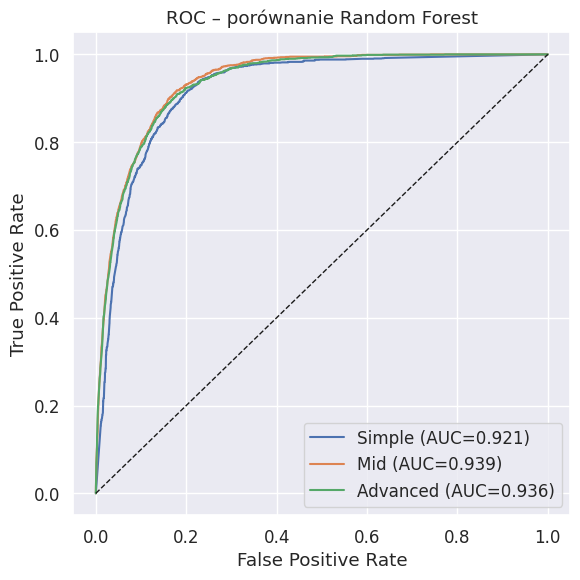

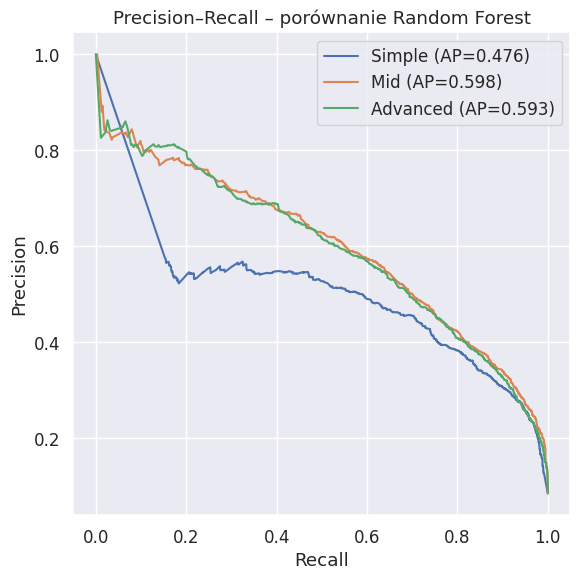

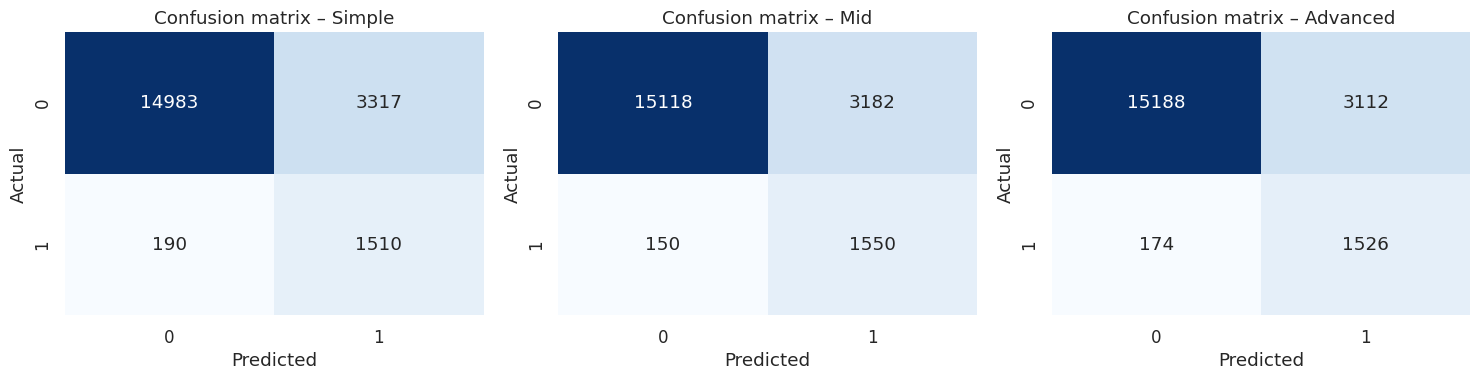

In [ ]:
models_dir = Path(os.getcwd()) / "models"  # katalog modeli
models = {
    "Simple":   joblib.load(models_dir / "rf_simple.joblib"),  # ładowanie modelu prostego
    "Mid":      joblib.load(models_dir / "rf_mid.joblib"),     # ładowanie modelu umiarkowanego
    "Advanced": joblib.load(models_dir / "rf_advanced.joblib"),# ładowanie modelu zaawansowanego
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # walidacja krzyżowa
records = []  # lista wyników
curves  = {}  # słownik krzywych

for tag, model in models.items():  # iteracja po modelach
    cv_res = cross_validate(  # walidacja krzyżowa metryk
        model,
        X_train_rf_proc,
        y_train,
        cv=cv,
        scoring={
            "ROC_AUC": "roc_auc",
            "Accuracy": "accuracy",
            "BalAcc": "balanced_accuracy",
            "Precision": "precision",
            "Recall": "recall",
            "F1": "f1",
        },
        n_jobs=-1,
        return_train_score=False
    )

    y_proba = model.predict_proba(X_test_rf_proc)[:, 1]  # prawdopodobieństwa klasy pozytywnej
    y_pred  = model.predict(X_test_rf_proc)  # predykcje klas

    rec = {  # słownik metryk
        "Model":        tag,
        "CV_ROC_AUC":   cv_res["test_ROC_AUC"].mean(),  # średnia AUC z CV
        "CV_Accuracy":  cv_res["test_Accuracy"].mean(),  # średnia Accuracy z CV
        "CV_BalAcc":    cv_res["test_BalAcc"].mean(),    # średnia BalAcc z CV
        "CV_Precision": cv_res["test_Precision"].mean(), # średnia Precision z CV
        "CV_Recall":    cv_res["test_Recall"].mean(),    # średnia Recall z CV
        "CV_F1":        cv_res["test_F1"].mean(),        # średnia F1 z CV
        "Test_Accuracy":      accuracy_score(y_test, y_pred),                   # Accuracy testu
        "Test_BalAcc":        balanced_accuracy_score(y_test, y_pred),         # BalAcc testu
        "Test_Precision":     precision_score(y_test, y_pred, zero_division=0),# Precision testu
        "Test_Recall":        recall_score(y_test, y_pred, zero_division=0),   # Recall testu
        "Test_F1":            f1_score(y_test, y_pred, zero_division=0),       # F1 testu
        "Test_ROC_AUC":       roc_auc_score(y_test, y_proba),                  # AUC ROC testu
        "Test_PR_AUC":        average_precision_score(y_test, y_proba),        # AUC Precision–Recall testu
        "Test_MCC":           matthews_corrcoef(y_test, y_pred),               # współczynnik MCC testu
    }
    records.append(rec)  # dodanie rekordu do listy

    fpr, tpr, _ = roc_curve(y_test, y_proba)  # punkty krzywej ROC
    prec, rec_, _ = precision_recall_curve(y_test, y_proba)  # punkty krzywej Precision–Recall
    curves[tag] = {"fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec_}  # zapis krzywych

metrics_df = pd.DataFrame(records).set_index("Model").round(3)  # DataFrame metryk
display(metrics_df)  # wyświetlenie tabeli metryk

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu ROC
for tag, pts in curves.items():  # iteracja po krzywych
    auc = metrics_df.loc[tag, "Test_ROC_AUC"]  # odczyt AUC ROC
    plt.plot(pts["fpr"], pts["tpr"], label=f"{tag} (AUC={auc:.3f})")  # rysowanie krzywej
plt.plot([0, 1], [0, 1], "k--", lw=1)  # linia losowa
plt.xlabel("False Positive Rate")  # etykieta osi X
plt.ylabel("True Positive Rate")  # etykieta osi Y
plt.title("ROC – porównanie Random Forest")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu Precision–Recall
for tag, pts in curves.items():  # iteracja po krzywych
    ap = metrics_df.loc[tag, "Test_PR_AUC"]  # odczyt AUC PR
    plt.plot(pts["rec"], pts["prec"], label=f"{tag} (AP={ap:.3f})")  # rysowanie krzywej
plt.xlabel("Recall")  # etykieta osi X
plt.ylabel("Precision")  # etykieta osi Y
plt.title("Precision–Recall – porównanie Random Forest")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

SHOW_CM = True  # flaga wyświetlania macierzy pomyłek
if SHOW_CM:
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))  # siatka dla macierzy
    for ax, (tag, model) in zip(axes, models.items()):  # iteracja po modelach
        cm = confusion_matrix(y_test, model.predict(X_test_rf_proc))  # macierz pomyłek
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)  # rysowanie macierzy
        ax.set_title(f"Confusion matrix – {tag}")  # tytuł pod wykresem
        ax.set_xlabel("Predicted")  # etykieta osi X
        ax.set_ylabel("Actual")  # etykieta osi Y
    plt.tight_layout()  # dopasowanie układu
    plt.show()  # wyświetlenie macierzy pomyłek
